<a href="https://colab.research.google.com/github/phandangthoai/Optimal_Scalogram_for_Computational_Complexity_Reduction_in_Acoustic_Recognition_Using_Deep_Learning/blob/main/Optimal_Scalogram_for_Computational_Complexity_Reduction_in_Acoustic_Recognition_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the library for downloading files from internet
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=aeb7edfdef1aa69f2e12da8fbd049ecd2207a757cc0e7de843653e9022495dc3
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
# Download audio dataset
import wget
url = "https://zenodo.org/records/3384388/files/-6_dB_slider.zip?download=1"
wget.download(url, '/content/m6dB_slider.zip')

In [ ]:
# Extract audios from zip file

# importing required modules
from zipfile import ZipFile

# specifying the zip file name
file_name = "/content/m6dB_slider.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
import shutil

In [ ]:
# If data is already in drive, copy it to this Colab session
src_path = '/content/drive/MyDrive/MIMII_data/m6dB/slider/id_00'
dst_path = '/content/m6dB/slider/id_00'
shutil.copytree(src_path, dst_path)
print('Copied')


Copied


In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import os
import librosa
import librosa.display
import IPython.display as ipd
import IPython
import numpy as np
import random
import pathlib
import gc  # Import garbage collection module
import pywt

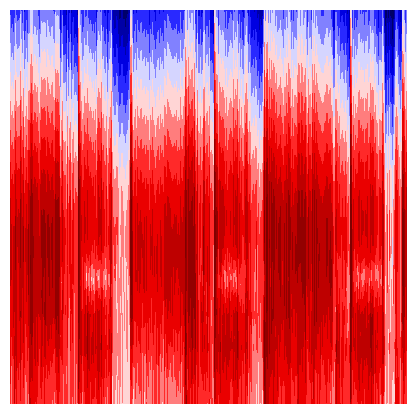

In [ ]:
dir_path = '/content/m6dB/slider/id_00'
cmap = plt.cm.seismic
contourlevels = np.arange(-6, 7)
signal_length = 160000 # Length of audio data (10s, sampled at 16kHz)
# Hop_size defines how large a step in extracting scalogram
# The large hop_size, the more computational complexity reduction, the lower tranform resolution
# Hop_size = 1, the transform equals to function pywt.cwt()
HOP_SIZE = 1
output_length = int(signal_length/HOP_SIZE)
# wavelet_length defines how long the wavelet kernel is
# longer wavelet results more resolution in transform, higher computational complexity
WAVELET_LENGTH = 64 # wavelet_length = 64 means 64 samples in the wavelet

# Define the Morlet wavelet's first derivative (approximated using Gaussian derivative)
def morlet_wavelet(t, sigma=1.0):
    """First derivative of the Morlet wavelet (approximated by Gaussian derivative)."""
    return -t * np.exp(-t**2 / (2 * sigma**2))  # First derivative of Gaussian
wavelet_time = np.linspace(-10, 10, WAVELET_LENGTH)  # Define wavelet range
# with sigma=1.0, the precision is about 3 or 5 considered as good precision
# choose precision = 10 for a better signal coverage
# this precision parameter does not impact the computational complexity
# Define scales for CWT
scales = np.arange(1, 129)
scales_log2 = np.log2(scales)

# Select specific time points for sparse computation
selected_times = np.linspace(0, signal_length - 2, output_length, dtype=int)  # Adjusted for np.diff size reduction

# Compute sparse CWT using Convolution + Differentiation
coeff_sparse = np.zeros((len(scales), len(selected_times)))  # Output matrix

types = 'normal abnormal'.split()
for g in types:
  pathlib.Path(f'{dir_path}/Sc_m6dBSlider00/{g}').mkdir(parents=True, exist_ok=True)
  for filename in os.listdir(f'{dir_path}/{g}'):
    sound = f'{dir_path}/{g}/{filename}'
    y, sr = librosa.load(sound, sr=None, mono=True, duration=10)
    y = y/max(abs(y)) #standardize sound
    # Reset coefficient matrix instead of reallocating
    coeff_sparse.fill(0)
    for i, scale in enumerate(scales):
        # Generate scaled wavelet
        wavelet_scaled = morlet_wavelet(wavelet_time / scale)
        wavelet_scaled /= np.sqrt(scale)  # Normalize
        # Perform convolution using FFT
        conv_result = fftconvolve(y, wavelet_scaled, mode='same')
        # Apply differentiation step
        conv_result_diff = -np.sqrt(scale) * np.diff(conv_result)
        # Store only selected time points
        coeff_sparse[i, :] = conv_result_diff[selected_times]
        del wavelet_scaled, conv_result, conv_result_diff
    power = 100*((coeff_sparse) ** 2)
    fig, ax = plt.subplots(figsize=(5.12, 5.12))
    im = ax.contourf(selected_times, scales_log2, np.log2(power), contourlevels, extend='both',cmap=cmap)
    plt.axis('off')
    break # use this break to generate one file only
    plt.savefig(f'{dir_path}/Sc_m6dBSlider00/{g}/{filename[:-3].replace(".", "")}.png', bbox_inches='tight')
    plt.clf()
    plt.close(fig)
    del fig, ax, im, power, y, sound, sr  # Explicitly delete large objects
    gc.collect()  # Force garbage collection
  break # use this break to generate one file only

In [ ]:
# copy the generated scalogram from drive if you have done so
src_path = '/content/drive/MyDrive/MIMII_data/m6dB/slider/id_00/Sc_m6dBSlider_00'
dst_path = '/content/m6dB/slider/id_00/Sc_m6dBSlider_00'
shutil.copytree(src_path, dst_path)
print('Copied')

In [ ]:
import tensorflow as tf
import keras

In [ ]:
# Training and validation for acoustic recognition task
batch_size = 64
img_height = 512
img_width = 512
data_dir = '/content/m6dB/slider/id_00/Sc_m6dBSlider_00'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = "inferred",
    label_mode = 'categorical',
    class_names = ('normal', 'abnormal'),
    color_mode = "rgb",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = "inferred",
    label_mode = 'categorical',
    class_names = ('normal', 'abnormal'),
    color_mode = "rgb",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

num_classes = 2

metrics = [
           'accuracy',
           tf.keras.metrics.AUC(
              num_thresholds=200, curve='ROC',
              summation_method='interpolation', name='AUC_ROC', dtype=None,
              thresholds=None, multi_label=False,
              num_labels=None,
              label_weights=None,
              from_logits=False),
           tf.keras.metrics.Precision(
              thresholds=None, top_k=None,
              class_id=None, name=None, dtype=None),
           tf.keras.metrics.Recall(
              thresholds=None, top_k=None, class_id=None,
              name=None, dtype=None)
]

model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(16, 3, activation='relu', use_bias=True, bias_initializer='zeros'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu', use_bias=True, bias_initializer='zeros'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu', use_bias=True, bias_initializer='zeros'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(units=num_classes, activation='softmax')
    ])
opt = tf.keras.optimizers.Adam(learning_rate=0.001,name='Adam')
model.compile(
  optimizer=opt,
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=metrics)

checkpoint_filepath = '/content/Sc_m6dBSlider_00_model_auc.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_AUC_ROC',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=32,
    callbacks=[model_checkpoint_callback])

Found 1424 files belonging to 2 classes.
Using 1140 files for training.
Found 1424 files belonging to 2 classes.
Using 284 files for validation.
Epoch 1/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - AUC_ROC: 0.6520 - accuracy: 0.5782 - loss: 1.8253 - precision: 0.5782 - recall: 0.5782 
Epoch 1: val_AUC_ROC improved from -inf to 0.88130, saving model to /content/Sc_m6dBSlider_00_model_auc.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 400s 22s/step - AUC_ROC: 0.6553 - accuracy: 0.5831 - loss: 1.7910 - precision: 0.5831 - recall: 0.5831 - val_AUC_ROC: 0.8813 - val_accuracy: 0.7465 - val_loss: 0.4700 - val_precision: 0.7465 - val_recall: 0.7465
Epoch 2/32
